In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import shutil
import glob
from matplotlib import image
from keras.preprocessing.image import load_img,img_to_array
from keras.applications.mobilenet import MobileNet,preprocess_input

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
!unzip /content/drive/MyDrive/brain_tumor_dataset.zip

Archive:  /content/drive/MyDrive/brain_tumor_dataset.zip
   creating: brain_tumor_dataset/
   creating: brain_tumor_dataset/test/
   creating: brain_tumor_dataset/test/yes/
  inflating: brain_tumor_dataset/test/yes/Y113.JPG  
  inflating: brain_tumor_dataset/test/yes/Y165.JPG  
  inflating: brain_tumor_dataset/test/yes/Y116.JPG  
  inflating: brain_tumor_dataset/test/yes/Y154.jpg  
  inflating: brain_tumor_dataset/test/yes/Y97.JPG  
  inflating: brain_tumor_dataset/test/yes/Y95.jpg  
  inflating: brain_tumor_dataset/test/yes/Y157.JPG  
  inflating: brain_tumor_dataset/test/yes/Y103.jpg  
  inflating: brain_tumor_dataset/test/yes/Y100.JPG  
  inflating: brain_tumor_dataset/test/yes/Y99.JPG  
  inflating: brain_tumor_dataset/test/yes/Y164.JPG  
  inflating: brain_tumor_dataset/test/yes/Y158.JPG  
  inflating: brain_tumor_dataset/test/yes/Y117.JPG  
  inflating: brain_tumor_dataset/test/yes/Y120.JPG  
  inflating: brain_tumor_dataset/test/yes/Y98.JPG  
  inflating: brain_tumor_dataset/tes

In [5]:
from keras.layers import Conv2D,MaxPool2D,Dropout,Flatten,Dense,BatchNormalization,GlobalAvgPool2D
from keras.models import Sequential 
from keras.preprocessing.image import ImageDataGenerator
import keras

# Bulid model

In [6]:
#cnn model
"""
model=Sequential()
model.add(Conv2D(filters=16, kernel_size=(3,3),activation='relu',input_shape=(224,224,3)))
model.add(Conv2D(filters=36, kernel_size=(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D (filters=64, kernel_size=(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Dropout(rate=0.25))

model.add(Flatten())
model.add(Dense(units=64,activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(units=1,activation='sigmoid'))

model.summary()
"""

"\nmodel=Sequential()\nmodel.add(Conv2D(filters=16, kernel_size=(3,3),activation='relu',input_shape=(224,224,3)))\nmodel.add(Conv2D(filters=36, kernel_size=(3,3),activation='relu'))\nmodel.add(MaxPool2D(pool_size=(2,2)))\n\nmodel.add(Conv2D (filters=64, kernel_size=(3,3),activation='relu'))\nmodel.add(MaxPool2D(pool_size=(2,2)))\n\nmodel.add(Conv2D(filters=128, kernel_size=(3,3),activation='relu'))\nmodel.add(MaxPool2D(pool_size=(2,2)))\n\nmodel.add(Dropout(rate=0.25))\n\nmodel.add(Flatten())\nmodel.add(Dense(units=64,activation='relu'))\nmodel.add(Dropout(rate=0.25))\nmodel.add(Dense(units=1,activation='sigmoid'))\n\nmodel.summary()\n"

In [7]:
#model.compile(optimizer='adam',loss=keras.losses.binary_crossentropy,metrics=['accuracy'])

# preparing data using data generator

In [8]:
def preprocessingimages_train(path):
  """
  input :path
  outout:preprocessed images
  """
  image_data=ImageDataGenerator(zoom_range=0.2,shear_range=0.2,preprocessing_function=preprocess_input
                                ,horizontal_flip=True) 
  image=image_data.flow_from_directory(directory=path,target_size=(224,224),batch_size=32,class_mode='binary')

  return image

In [9]:
path='/content/brain_tumor_dataset/train'
train_data=preprocessingimages_train(path)

Found 2946 images belonging to 2 classes.


In [10]:
def preprocessingimages_test_val(path):
  """
  input :path
  outout:preprocessed images
  """
  image_data=ImageDataGenerator(preprocessing_function=preprocess_input) 
  image=image_data.flow_from_directory(directory=path,target_size=(224,224),batch_size=32,class_mode='binary')

  return image

In [11]:
path='/content/brain_tumor_dataset/test'
test_data=preprocessingimages_test_val(path)

Found 61 images belonging to 2 classes.


In [12]:
path='/content/brain_tumor_dataset/val'
val_data=preprocessingimages_test_val(path)

Found 49 images belonging to 2 classes.


# early stopping and model check point

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Flatten,Dense
from keras.models import Model,load_model
from keras.applications.mobilenet import MobileNet

In [14]:
base_model=MobileNet(input_shape=(224,224,3),include_top=False)

17235968/17225924 [==============================] - 0s 0us/step


In [15]:
for layer in base_model.layers:
  layer.trainable=False

In [16]:
x=Flatten()(base_model.output)
x=Dense(units=1,activation='sigmoid')(x)

model=Model(base_model.input,x)

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

In [18]:
model.compile(optimizer='rmsprop',loss=keras.losses.binary_crossentropy,metrics=['accuracy'])

In [19]:
from keras.callbacks import ModelCheckpoint,EarlyStopping
#early stopping
es=EarlyStopping(monitor='val_accuracy',min_delta=0.01,patience=5,verbose=1)
#model check point
mc=ModelCheckpoint(monitor='val_accuracy',filepath="./bestmodel.h5",verbose=1,save_best_only=True)
cd=[es,mc]

In [20]:
hist=model.fit_generator(train_data,steps_per_epoch=1000
                         ,epochs=30
                         ,validation_data=val_data
                         ,validation_steps=16,callbacks=cd)

Epoch 1/30
  93/1000 [=>............................] - ETA: 5:49 - loss: 1.8221 - accuracy: 0.8503WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 30000 batches). You may need to use the repeat() function when building your dataset.

Epoch 1: val_accuracy improved from -inf to 0.91837, saving model to ./bestmodel.h5
1000/1000 [==============================] - 49s 37ms/step - loss: 1.8221 - accuracy: 0.8503 - val_loss: 0.5887 - val_accuracy: 0.9184


In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
#load the best fit model
model=load_model('/content/bestmodel.h5')

In [29]:
from keras import models
acc=model.evaluate_generator(test_data)[1]
print(f'our model acc is {acc*100}%')

our model acc is 98.36065769195557%


In [24]:
h= hist.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

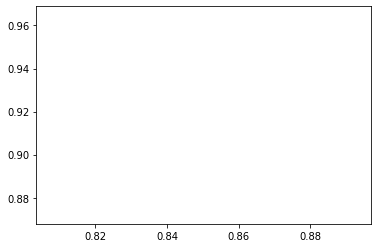

Text(0.5, 1.0, 'acc vs val_acc')

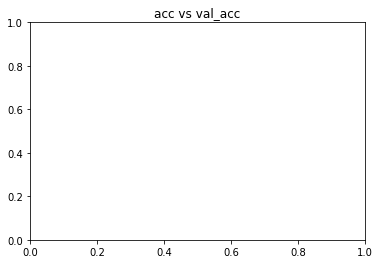

In [25]:
plt.plot(h['accuracy'],h['val_accuracy'])



plt.show()
plt.title('acc vs val_acc')

In [26]:
from keras.preprocessing import image

In [32]:
from keras.applications.imagenet_utils import preprocess_input
path='/content/brain_tumor_dataset/train/yes/Y12.jpg'

img=image.load_img(path,target_size=(224,224))

i=image.img_to_array(img)/255


input_arr=np.array([i])
input_arr.shape

pred=np.argmax(model.predict(input_arr))

if pred == 1:
  print('the MRI is having a Tumor')
else:
  print('the MRI is NOT having a Tumor')  


the MRI is NOT having a Tumor


In [28]:
train_data.class_indices

{'no': 0, 'yes': 1}